## Adam convergence problem

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np

We will solve the online optimization problem for function  $f_t(x) = \begin{cases} 1010x, \text{for t mod 101} = 1 \\ 
-10x, otherwise \end{cases}$

Online optimization task: $ F(x) = \sum_t f_t(x)  \to min_x$

with the constraint set $\mathcal{F} =[-1, 1]$

The analitical solution for this task is $x^*=-1$

In order to understand the problems of Adam, we denote the concept of "regret": $R_T = \sum\limits_{t=1}^T f_t(x_t) - \min\limits_{x \in \mathcal{F}} \sum\limits_{t=1}^T f_t(x)$

The regret should tend to zero during optimization, it implies that on average,
the model’s performance converges to the optimal one.

In [2]:
loss_buffer = []

In [3]:
import adashift.optimizers as ad_opt

In [4]:
x_max = torch.tensor([1.0], requires_grad=True)
x_min = torch.tensor([-1.0], requires_grad=True)

def online_f_t(x, t):
    if t % 101 == 1:
        return 1010.0*x
    else:
        return -10.0*x
    
def f_min(t):
    if t % 101 == 1:
        return -1010.0
    else:
        return 10.0

def domain_constraints(x):
    if x > 1.0:
        return x_max
    if x < -1.0:
        return x_min
    return x

In [8]:
def OnlineLearning(optimizer_type='Adam',learning_rate=1e-3, amsgrad=False, max_step = 1000001):
    x = torch.tensor([0.25], requires_grad=True)
    if optimizer_type == "Adam":
        optimizer = torch.optim.Adam([x], amsgrad=amsgrad, lr=learning_rate, betas=(0.9, 0.99), eps=1e-8)
    else:
        optimizer = ad_opt.AdaShift([x], lr=learning_rate, betas=(0.9, 0.99), eps=1e-8)
    regret_sum = 0
    time_steps = []
    avg_regret_history = []
    x_history = []

    for step in range(1, max_step):
        x = domain_constraints(x)
        loss = online_f_t(x, step)

        regret_sum += (loss.item() - f_min(step))
        regret_avg = regret_sum/step
    
        optimizer.zero_grad()
        loss.backward()
        
        x_history.append(x.item())

        if step % 1000 == 0:
            time_steps.append(step)
            avg_regret_history.append(regret_avg)
        if step % 50000 == 0:
            print ('step : ',step, '  loss : ',loss.item() , ' regret_avg : ',regret_avg )
        
        optimizer.step()   
    return time_steps, avg_regret_history, x_history

In [6]:
lr = 1e-1

time_steps, avg_regret_history, x_history = OnlineLearning(learning_rate=lr)

step :  50000   loss :  -10.0  regret_avg :  0.25749269977115097
step :  100000   loss :  -10.0  regret_avg :  0.22674634988557546
step :  150000   loss :  -10.0  regret_avg :  0.21649756659038366
step :  200000   loss :  -10.0  regret_avg :  0.21137317494278773
step :  250000   loss :  -10.0  regret_avg :  0.2082985399542302
step :  300000   loss :  -10.0  regret_avg :  0.20624878329519183
step :  350000   loss :  -10.0  regret_avg :  0.20478467139587872
step :  400000   loss :  -10.0  regret_avg :  0.20368658747139387
step :  450000   loss :  -10.0  regret_avg :  0.20283252219679454
step :  500000   loss :  -10.0  regret_avg :  0.2021492699771151
step :  550000   loss :  -10.0  regret_avg :  0.201590245433741
step :  600000   loss :  -10.0  regret_avg :  0.2011243916475959
step :  650000   loss :  -10.0  regret_avg :  0.20073020767470393
step :  700000   loss :  -10.0  regret_avg :  0.20039233569793935
step :  750000   loss :  -10.0  regret_avg :  0.20009951331807674
step :  800000  

In [9]:
amsgrad_time_steps, amsgrad_avg_regret_history, amsgrad_x_history = OnlineLearning(amsgrad=True, learning_rate=lr)

step :  50000   loss :  10.0  regret_avg :  0.6872470705077797
step :  100000   loss :  10.0  regret_avg :  0.34362353525388983
step :  150000   loss :  10.0  regret_avg :  0.22908235683592656
step :  200000   loss :  10.0  regret_avg :  0.17181176762694492
step :  250000   loss :  10.0  regret_avg :  0.13744941410155595
step :  300000   loss :  10.0  regret_avg :  0.11454117841796328
step :  350000   loss :  10.0  regret_avg :  0.09817815292968282
step :  400000   loss :  10.0  regret_avg :  0.08590588381347246
step :  450000   loss :  10.0  regret_avg :  0.07636078561197553
step :  500000   loss :  10.0  regret_avg :  0.06872470705077798
step :  550000   loss :  10.0  regret_avg :  0.062477006409798155
step :  600000   loss :  10.0  regret_avg :  0.05727058920898164
step :  650000   loss :  10.0  regret_avg :  0.05286515926982921
step :  700000   loss :  10.0  regret_avg :  0.04908907646484141
step :  750000   loss :  10.0  regret_avg :  0.045816471367185314
step :  800000   loss :  

In [10]:
adashift_time_steps, adashift_avg_regret_history, adashift_x_history = OnlineLearning(learning_rate=lr, optimizer_type='Adashift')

step :  50000   loss :  -10.0  regret_avg :  0.22313361695289613
step :  100000   loss :  -10.0  regret_avg :  0.20956680847644807
step :  150000   loss :  -10.0  regret_avg :  0.2050445389842987
step :  200000   loss :  -10.0  regret_avg :  0.20278340423822402
step :  250000   loss :  -10.0  regret_avg :  0.2014267233905792
step :  300000   loss :  -10.0  regret_avg :  0.20052226949214935
step :  350000   loss :  -10.0  regret_avg :  0.19987623099327087
step :  400000   loss :  -10.0  regret_avg :  0.199391702119112
step :  450000   loss :  -10.0  regret_avg :  0.19901484632809957
step :  500000   loss :  -10.0  regret_avg :  0.1987133616952896
step :  550000   loss :  -10.0  regret_avg :  0.19846669245026327
step :  600000   loss :  -10.0  regret_avg :  0.19826113474607468
step :  650000   loss :  -10.0  regret_avg :  0.19808720130406893
step :  700000   loss :  -10.0  regret_avg :  0.19793811549663543
step :  750000   loss :  -10.0  regret_avg :  0.19780890779685975
step :  800000  

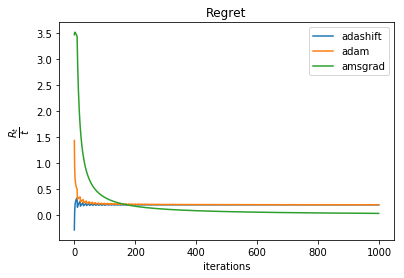

In [14]:
plt.title("Regret")
plt.plot(adashift_avg_regret_history, label='adashift')
plt.plot(avg_regret_history,label='adam')
plt.plot(amsgrad_avg_regret_history,label='amsgrad')
plt.xlabel("iterations")
plt.ylabel(r"$\dfrac{R_t}{t}$")
plt.legend()
plt.show()

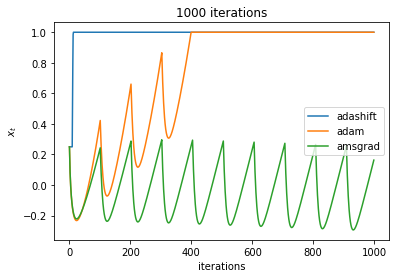

In [16]:
plt.title("1000 iterations")
plt.plot(adashift_x_history[:1000], label='adashift')
plt.plot(x_history[:1000],label='adam')
plt.plot(amsgrad_x_history[:1000],label='amsgrad')
plt.legend()
plt.xlabel("iterations")
plt.ylabel(r"$x_t$")
plt.show()